In [197]:
import copy
import json
import numpy as np
import pandas as pd

import sys
import os
import parser
import time

import preprocessing
from preprocessing import elapsed

# Plotting
import matplotlib.pyplot as plt
from plotnine import *

In [198]:
traits = [
    'body_HEIGHTz', 
    'disease_CARDIOVASCULAR', 
    'biochemistry_HDLcholesterol',
    'biochemistry_LDLdirect'
]
COLORS = [
    # 'cornflowerblue',
    # 'mediumaquamarine', #'aquamarine is pretty but hard to see, similarly for springgren
    # 'orangered',
    # 'pink',
    # 'gray',
    # 'gold'
    '#019E73', # blue-ish green
    'cornflowerblue', # blue
    "orangered", #'#D55E01', # red/vermillon
    '#F0E442', # yellow
    #'#BBBBBB', # gray
    #'#000000', # black
]
METHOD_NAMES = {
    #"spikeslab_blip":"LSS + BLiP",
    "susie_blip":"Susie + BLiP",
    "susie":"Susie",
    "susie-indiv-only":"susie (no groups)",
}

In [199]:
def calculate_overlap(rej1, rej2):
    snps1 = set([snp for x in rej1 for snp in x])
    snps2 = set([snp for x in rej2 for snp in x])
    overlap_snps = snps1.intersection(snps2)
    n1 = 0
    n2 = 0
    for x in rej1:
        if len(set(x).intersection(overlap_snps)) > 0:
            n1 +=1
    for x in rej2:
        if len(set(x).intersection(overlap_snps)) > 0:
            n2 += 1
    return n1, n2

### Analysis 1: overlap with susie model from Weissbrod et al. (2019)

In [200]:
def get_cols(method1, method2):
    return [
        f'Trait',
        f'Num. Disc. {method1}',
        f'Num. Confirmed by {method2}',
        f'Num. Disc. {method2}',
        f'Num. Confirmed by {method1}', 
    ]

method = 'susie_blip'
overlaps = []
for trait in traits:
    with open(f"output/final/rejections/rejections_{trait}.json", "r") as file:
        rej = json.load(file)
    nsusie = len(rej['susie'])
    nmethod = len(rej[method])
    rej_blip = [x['SNP_IDS'] for x in rej[method]]
    rej_susie = [x['SNP_IDS'] for x in rej['susie']]
    o1, o2 = calculate_overlap(rej_blip, rej_susie)
    overlaps.append([trait, nsusie, o2, nmethod, o1])        

cols = get_cols('susie', method)
overlaps = pd.DataFrame(overlaps, columns=cols)
overlaps['Trait'] = overlaps['Trait'].str.split("_").apply(lambda x: x[-1])
display(overlaps)

,Trait,Num. Disc. susie,Num. Confirmed by susie_blip,Num. Disc. susie_blip,Num. Confirmed by susie
0,HEIGHTz,1532,1532,1760,1540
1,CARDIOVASCULAR,101,101,124,101
2,HDLcholesterol,302,302,356,302
3,LDLdirect,156,156,182,157


In [211]:
overlaps['Num. Disc. susie_blip'] / overlaps['Num. Disc. susie']  

0    1.148825
1    1.227723
2    1.178808
3    1.166667
dtype: float64

In [213]:
 overlaps['Num. Confirmed by susie']/ overlaps['Num. Disc. susie_blip']

0    0.875000
1    0.814516
2    0.848315
3    0.862637
dtype: float64

### Analysis 2: overlap with Farh et al. (2015)

In [203]:
# load results from Farh et al. (2015)
farh_data = pd.read_excel("data/farh2015/41586_2015_BFnature13835_MOESM8_ESM.xls")
farh_data = farh_data.loc[
    (farh_data['PICS_probability'] > 0.95) &
    (farh_data['Disease'].isin(['HDL_cholesterol', 'LDL_cholesterol']))
]
farh_data['trait'] = farh_data['Disease'].map({
    'HDL_cholesterol':'biochemistry_HDLcholesterol',
    'LDL_cholesterol':'biochemistry_LDLdirect',
})

In [205]:
# Load rejections from SuSiE + BLiP
blip_rej = dict()
for trait in farh_data['trait'].unique():
    with open(f"output/final/rejections/rejections_{trait}.json", "r") as file:
        blip_rej[trait] = json.load(file)['susie_blip']
        
# Loop through discoveries from Farh 2015
common_discs = []
for i in range(farh_data.shape[0]):
    row = farh_data.iloc[i]
    snp = row['SNP']
    common_disc = None
    for x in blip_rej[row['trait']]:
        if snp in x['SNPS']:
            common_disc = x
    common_discs.append(common_disc)

fd = farh_data.copy()
fd['susie_blip_disc'] = common_discs
fd['Replicated by SuSiE + BLiP?'] = [
    'Yes' if x is not None else 'No' for x in common_discs
]
fd['Corresponding discovery']= [
    x['SNPS'] if x is not None else np.nan for x in common_discs
]

fd = fd.rename(columns={
    "PICS_probability":'PIP (Farh et al. (2015))',
})
cols = [
    'Disease',
    'SNP',
    'PIP (Farh et al. (2015))', 
    'Replicated by SuSiE + BLiP?',
    'Corresponding discovery'
]
fd[cols]

,Disease,SNP,PIP (Farh et al. (2015)),Replicated by SuSiE + BLiP?,Corresponding discovery
6163,HDL_cholesterol,rs581080,0.978,No,NaN
6198,HDL_cholesterol,rs964184,1.000,Yes,[rs964184]
6233,HDL_cholesterol,rs12229654,1.000,No,NaN
6234,HDL_cholesterol,rs2074356,1.000,No,NaN
6251,HDL_cholesterol,rs1532085,0.986,No,NaN
6363,HDL_cholesterol,rs1800961,1.000,Yes,[rs1800961]
6383,LDL_cholesterol,rs11591147,1.000,Yes,[rs11591147]
6549,LDL_cholesterol,rs964184,1.000,Yes,[rs964184]


### Analysis 2: main plots

In [206]:
# Read final data
loci_df_list = []
for trait in traits:
    with open(f"output/final/rejections/rejections_{trait}.json", "r") as file:
        rejections = json.load(file)

    # Load metadata about positions in chromosomes
    chromepos_file = f"main_cache/chromepos/{trait}_chromepos.csv"
    chrome_starts = pd.read_csv(chromepos_file)
    chrome_starts = chrome_starts.set_index("CHR")
    chrome_starts.index = chrome_starts.index.astype(int)
    chrome_starts['cum_bp'] = np.cumsum(chrome_starts['max_bp'])
    chrome_starts['cum_bp'] = chrome_starts['cum_bp'] - chrome_starts['max_bp']

    # Turn into dataframe
    snp_list = []
    loci_list = []
    methods = list(rejections.keys())
    methods = [m for m in methods if 'lfdr' not in m]
    methods = [m for m in methods if 'indiv' not in m]
    for method in methods:
        for x in rejections[method]:
            pep = x['pep']
            gsize = len(x['SNP_IDS'])
            chrome = x['CHR'][0]
            bp = x['BP'][0] + chrome_starts.loc[chrome, 'cum_bp']
            loci = int(bp / int(1e6) - 0.5)
            loci_list.append(
                [method, chrome, loci, 1, 1 / gsize, gsize, pep]
            )
            for j in range(len(x['BP'])):
                snp_list.append(
                    [method, x['BP'][j], 1 / gsize, gsize, pep]
                )

    ## Aggregated plots by loci for each trait
    loci_df = pd.DataFrame(
        loci_list, columns=['method', 'CHR', 'loci', 'ndisc', 'gap', 'gsize', 'pep']
    )
    loci_df['Method'] = loci_df['method'].map(METHOD_NAMES)
    
    # Ignore any other non-final methods
    loci_df = loci_df.loc[loci_df['Method'].notnull()]
    
    # Append
    loci_df['trait'] = trait.split("_")[1]
    loci_df_list.append(loci_df)

    # ## Plot for each discovered group / snp
    # snp_df = pd.DataFrame(
    # 	snp_list, columns=['method', 'bp', 'gap', 'group_size', 'pep']
    # )

In [207]:
### Version 2 of group_sizes plots
all_loci_df = pd.concat(loci_df_list, axis='index')
gsize_df = pd.DataFrame(all_loci_df.groupby(['Method', 'trait', 'gsize'])['CHR'].count())
gsize_df = gsize_df.rename({'CHR':'count'}, axis='columns').reset_index()
gsize_df = gsize_df.sort_values(['Method', 'trait','gsize'])
gsize_df['cum_count'] = gsize_df.groupby(['Method', 'trait'])['count'].cumsum()

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 8 x 2 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/final/plots/groupsizes.jpg
/home/asher/.local/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/home/asher/.local/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


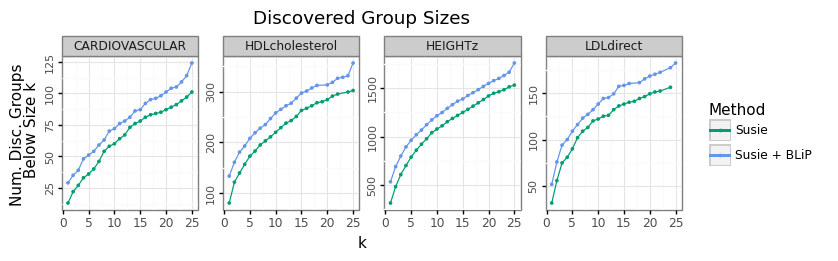

In [208]:
title = f"Discovered Group Sizes"
g = (
    ggplot(gsize_df, aes(x='gsize', y='cum_count', fill='Method', color='Method'))
        + geom_point(size=0.5)
        + geom_line()
        + labs(
            x="k", y="Num. Disc. Groups \n Below Size k", 
            title=title
        )
    + facet_wrap("~trait", scales="free_y", ncol=4)
    + scale_fill_manual(values=COLORS)
    + scale_color_manual(values=COLORS)
    + theme_bw()
    + theme(axis_text_x=element_text(angle = 0), figure_size=(8, 2))
    + theme(axis_text_y=element_text(angle = 90, size=8))
    + theme(panel_spacing_x=0.25)
)

g.save(f"output/final/plots/groupsizes.jpg", dpi=500)
print(g)

/home/asher/.local/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


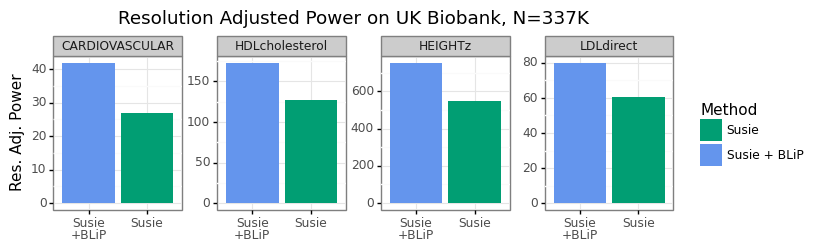

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 8 x 2 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/final/plots/gap.jpg
/home/asher/.local/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


In [209]:
# Plot overall group-adjusted power
gap_df = all_loci_df.groupby(['Method', 'trait'])['gap'].sum().reset_index()
mcmc_name = 'LSS\n+BLiP'
susie_blip_name = 'Susie\n+BLiP'
gap_df['Method1'] = gap_df['Method'].map({
    'LSS + BLiP':mcmc_name,
    'Susie':'Susie',
    'Susie + BLiP':susie_blip_name    
})
gap_df['Method1'] = pd.Categorical(
    gap_df['Method1'],
    ordered=True,
    categories=[mcmc_name, susie_blip_name, 'Susie']
)
g = (
    ggplot(gap_df, aes(x="Method1", y="gap", fill="Method")) 
    + geom_col(position='dodge') 
    + facet_wrap("~trait", scales='free_y', ncol=4)
    + scale_fill_manual(values=COLORS)
    + theme_bw()
    + theme(axis_text_x=element_text(angle = 0))
    + theme(figure_size=(8,2))
    + theme(panel_spacing_x=0.35)
    + labs(
        title=f"Resolution Adjusted Power on UK Biobank, N=337K", 
        y="Res. Adj. Power",
        x=''
    )
)
print(g)
g.save(f"output/final/plots/gap.jpg", dpi=500)


In [24]:
gap_df

,Method,trait,gap,Method1
0,Susie,CARDIOVASCULAR,26.972631,Susie
1,Susie,HDLcholesterol,126.428599,Susie
2,Susie,HEIGHTz,548.071214,Susie
3,Susie,LDLdirect,60.260870,Susie
4,Susie + BLiP,CARDIOVASCULAR,41.317045,Susie\n+BLiP
5,Susie + BLiP,HDLcholesterol,170.646775,Susie\n+BLiP
6,Susie + BLiP,HEIGHTz,743.116607,Susie\n+BLiP
7,Susie + BLiP,LDLdirect,79.218249,Susie\n+BLiP


In [25]:
blip_gap = gap_df.loc[gap_df['Method'] == 'Susie + BLiP'].sort_values('trait')['gap'].values
susie_gap = gap_df.loc[gap_df['Method'] == 'Susie'].sort_values('trait')['gap'].values
blip_gap / susie_gap

array([1.53181368, 1.34974821, 1.355876  , 1.31458854])

### Trying to visualize results

In [26]:
hm = all_loci_df.groupby(['CHR', 'loci', 'trait', 'method'])['gap'].sum().reset_index()
hm.loc[hm['CHR'] == 1].groupby(['trait', 'method'])[['gap']].sum().reset_index()

,trait,method,gap
0,CARDIOVASCULAR,susie,2.357367
1,CARDIOVASCULAR,susie_blip,3.096256
2,HDLcholesterol,susie,10.974275
3,HDLcholesterol,susie_blip,13.820357
4,HEIGHTz,susie,41.433035
5,HEIGHTz,susie_blip,57.501237
6,LDLdirect,susie,6.587302
7,LDLdirect,susie_blip,8.462302


/home/asher/.local/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


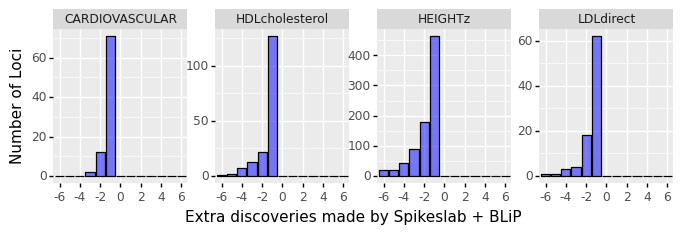

In [27]:
# Aggregate
meas = 'ndisc'
loc_ndisc_df = all_loci_df.groupby(['CHR', 'loci', 'trait', 'method'])[meas].sum()
loc_ndisc_df = loc_ndisc_df.reset_index()

# Merge across methods and take differences
merge_on = ['CHR', 'loci', 'trait']
cols = [meas] + merge_on
diff_df = pd.merge(
    loc_ndisc_df.loc[loc_ndisc_df['method'] == 'susie', cols],
    loc_ndisc_df.loc[loc_ndisc_df['method'] == 'spikeslab_blip', cols],
    on = merge_on,
    suffixes=('_susie', '_blip'),
    how='outer'
).fillna(0)
diff_df['diff2'] = diff_df[f'{meas}_blip'] - diff_df[f'{meas}_susie']

# Bin and count
bins = np.arange(14) - 6.5
diff_df['diff2_binned'] = pd.cut(diff_df['diff2'], bins=bins)
final_df = diff_df.groupby(['trait', 'diff2_binned'])[f'{meas}_blip'].count().reset_index()
final_df = final_df.rename(columns={f'{meas}_blip':'Count'})
final_df['bin_mid'] = final_df['diff2_binned'].apply(
    lambda x: int((x.left + x.right) / 2)
)
final_df['brightness'] = np.abs(final_df['bin_mid'].astype(float)) * final_df['Count']
final_df.loc[final_df['bin_mid'] == 0, 'Count'] = 0

g = (
    ggplot(final_df, aes(x='bin_mid', y='Count')) 
    + geom_col(
        #mapping=aes(alpha='brightness'),
        color='black',
        fill='blue',
        alpha=0.5,
    )
    + facet_wrap('~trait', scales='free', ncol=4)
    + scale_x_discrete(breaks=[-6, -4, -2, 0, 2, 4, 6])
    + theme(
        figure_size=(8,2), 
        panel_spacing_x=0.28,
    )
    + labs(
            x='Extra discoveries made by Spikeslab + BLiP',
        y='Number of Loci',
        alpha='Total num. disc'
    )
)
#g.save(f"output/final/plots/{savename}_disc_per_locus.jpg", dpi=500)
print(g)

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 8 x 2 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/final/plots/disc_per_locus.jpg


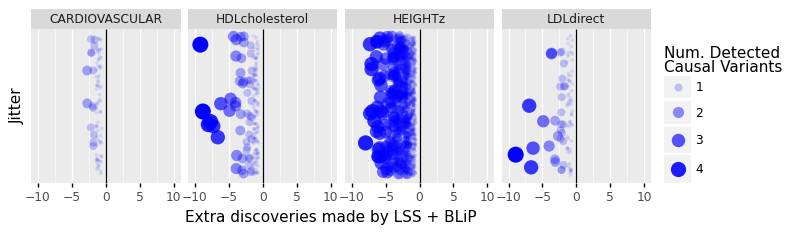

In [28]:
np.random.seed(1234)
diff_df['y'] = 0
diff_df['size'] = (
    diff_df[f'{meas}_susie'] + diff_df[f'{meas}_blip']
) / 2
diff_df['size2'] = np.power(diff_df['size'], 2) # area proportional to size, not radius
maxx = np.abs(diff_df['diff2']).max()


g = (
    ggplot(diff_df, aes(x='diff2', y='y')) 
    + geom_jitter(
        mapping=aes(
            size='size',#'np.power(size, 2)',
            alpha='size',
        ),
        color='none',
        fill='blue',
    )
    + facet_wrap('~trait', nrow=1, ncol=4, scales='fixed')
    + theme(
        figure_size=(8,2), 
        panel_spacing_x=0.28,
        legend_position=(0.99, 0.5),
    )
    + scale_x_continuous(limits=(-10, 10))
    #+ scale_size_continuous(guide=None)
    + labs(
        x='Extra discoveries made by LSS + BLiP',
        y='Jitter',
        size='Num. Detected\nCausal Variants\n',
        alpha='Num. Detected\nCausal Variants\n',
    )
)
# Add y = 0 verticale line
g += geom_vline(aes(xintercept=0))
g += theme(axis_text_y=element_blank())
g += scale_y_continuous(breaks=None)
g += theme(subplots_adjust={'wspace':0.05})
g.save(f"output/final/plots/disc_per_locus.jpg", dpi=500)
print(g)

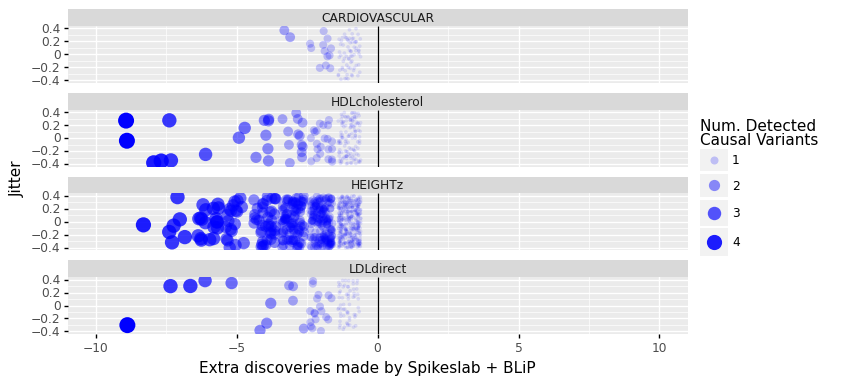

In [29]:
np.random.seed(1234)
diff_df['y'] = 0
diff_df['size'] = (
    diff_df[f'{meas}_susie'] + diff_df[f'{meas}_blip']
) / 2
maxx = np.abs(diff_df['diff2']).max()


g = (
    ggplot(diff_df, aes(x='diff2', y='y')) 
    + geom_jitter(
        mapping=aes(
            size='size',#'np.power(size, 2)',
            alpha='size',
        ),
        color='none',
        fill='blue',
    )
    + facet_wrap('~trait', nrow=4, ncol=1, scales='fixed')
    + theme(
        figure_size=(8,4), 
        panel_spacing_x=0.28,
        legend_position=(0.99, 0.5),
    )
    + scale_x_continuous(limits=(-10, 10))
    + labs(
        x='Extra discoveries made by Spikeslab + BLiP',
        y='Jitter',
        size='Num. Detected\nCausal Variants\n',
        alpha='Num. Detected\nCausal Variants\n',
    )
)
# Add y = 0 verticale line
g += geom_vline(aes(xintercept=0))

print(g)

In [30]:
methods = ['MCMC + BLiP', 'Susie + BLiP']
for method, savename in zip(methods, ['spikeslab', 'susieblip']):
    sub_susie = loc_ndisc_df.loc[loc_ndisc_df['Method'] == 'Susie']
    sub_method = loc_ndisc_df.loc[loc_ndisc_df['Method'] == method]
    merge_cols = ['CHR', 'loci', 'trait']
    cols = merge_cols + [meas]
    mdf = pd.merge(
        sub_susie[cols],
        sub_method[cols], 
        on=merge_cols,
        suffixes=('_susie', '_blip'),
        how='outer'
    )
    mdf = mdf.fillna(0)

    xeqys = []
    for trait in mdf['trait'].unique():
        xeqy = pd.DataFrame()
        mval = np.ceil(max(
            mdf.loc[mdf['trait'] == trait, f'{meas}_blip'].max(), 
            mdf.loc[mdf['trait'] == trait, f'{meas}_susie'].max(),
        ))
        xeqy['x'] = np.arange(mval)
        xeqy['y'] = np.arange(mval)
        xeqy['trait'] = trait
        xeqys.append(xeqy)
    xeqys = pd.concat(xeqys)

    g = (
        ggplot(mdf, aes(x=f'{meas}_susie', y=f'{meas}_blip')) 
        + geom_point(
            fill='blue', color='blue', stroke=0, size=1.5,
            mapping=aes(alpha='np.maximum(gap_blip, gap_susie)')
        )
        + geom_line(
            data=xeqys, mapping=aes(x='x', y='y'), 
            linetype='dashed', color='black'
        )
        + facet_wrap('~trait', scales='free', ncol=4)
        + theme(
            figure_size=(8,2), 
            panel_spacing_x=0.28,
        )
        + labs(x="Num. Disc. per Locus (Susie)", y=f"Num. Disc. per Locus\n({method})")
    )
    #g.save(f"output/final/plots/{savename}_disc_per_locus.jpg", dpi=500)
    print(g)

KeyError: 'Method'

### Option 2

In [14]:
meas = 'ndisc'
loc_ndisc_df = all_loci_df.groupby(['CHR', 'loci', 'trait', 'Method'])[meas].sum()
loc_ndisc_df = loc_ndisc_df.reset_index()

/home/asher/.local/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/home/asher/.local/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


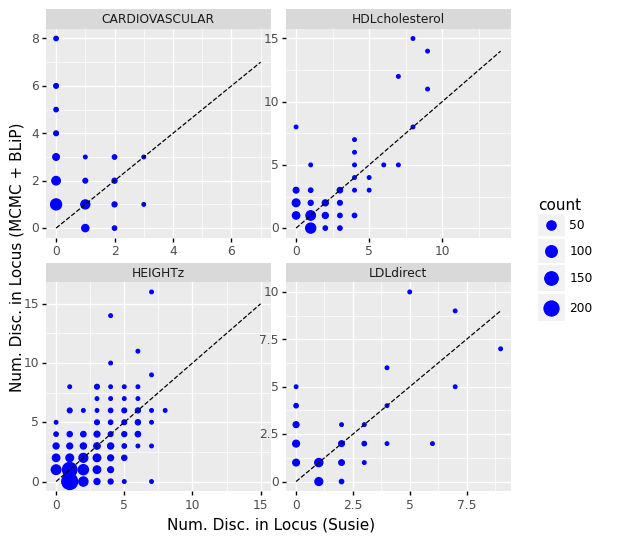

<ggplot: (8792557660368)>

In [15]:
method = 'MCMC + BLiP'
sub_susie = loc_ndisc_df.loc[loc_ndisc_df['Method'] == 'Susie']
sub_method = loc_ndisc_df.loc[loc_ndisc_df['Method'] == method]
merge_cols = ['CHR', 'loci', 'trait']
cols = merge_cols + [meas]
mdf = pd.merge(
    sub_susie[cols],
    sub_method[cols], 
    on=merge_cols,
    suffixes=('_susie', '_blip'),
    how='outer'
)
mdf = mdf.fillna(0)

counts = mdf.groupby(
    [f'{meas}_susie', f'{meas}_blip', 'trait']
)['loci'].count().reset_index().rename(columns={'loci':'count'})

xeqys = []
for trait in counts['trait'].unique():
    xeqy = pd.DataFrame()
    mval = np.ceil(max(
        counts.loc[counts['trait'] == trait, f'{meas}_blip'].max(), 
        counts.loc[counts['trait'] == trait, f'{meas}_susie'].max(),
    ))
    xeqy['x'] = np.arange(mval)
    xeqy['y'] = np.arange(mval)
    xeqy['trait'] = trait
    xeqys.append(xeqy)
xeqys = pd.concat(xeqys)


g = (
    ggplot(counts, aes(x=f'{meas}_susie', y=f'{meas}_blip', size='count')) 
    + geom_point(fill='blue', color='blue')
    + geom_line(
        data=xeqys, mapping=aes(x='x', y='y'), 
        linetype='dashed', color='black', inherit_aes=False
    )
    + facet_wrap('~trait', scales='free')
    + theme(
        figure_size=(6,6), 
        panel_spacing_x=0.15,
        panel_spacing_y=0.25,
    )
    + labs(x="Num. Disc. in Locus (Susie)", y=f"Num. Disc. in Locus ({method})")
)
g


# g = (
#     ggplot(mdf, aes(x=f'{meas}_susie', y=f'{meas}_blip')) 
#     + geom_point(fill='blue', alpha=0.25, color='blue')
#     + geom_line(
#         data=xeqys, mapping=aes(x='x', y='y'), 
#         linetype='dashed', color='black'
#     )
#     + facet_wrap('~trait', scales='free')
#     + theme(
#         figure_size=(6,6), 
#         panel_spacing_x=0.15,
#         panel_spacing_y=0.25,
#     )
#     + labs(x="Num. Disc. in Locus (Susie)", y=f"Num. Disc. in Locus ({method})")
# )
# g